In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [2]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)

In [4]:
list(dataset.keys())

['train', 'test']

In [5]:
ex = next(iter(dataset['train']))
ex.keys(), ex['image'].shape, ex['segmentation_mask'].shape

(dict_keys(['file_name', 'head_bbox', 'image', 'label', 'segmentation_mask', 'species']),
 TensorShape([500, 500, 3]),
 TensorShape([500, 500, 1]))

In [6]:
ex = next(iter(dataset['test']))
ex.keys(), ex['image'].shape, ex['segmentation_mask'].shape

(dict_keys(['file_name', 'head_bbox', 'image', 'label', 'segmentation_mask', 'species']),
 TensorShape([500, 403, 3]),
 TensorShape([500, 403, 1]))

In [7]:
info.version, info.splits, info.splits['train'].num_examples

(Version('4.0.0'),
 {'train': <SplitInfo num_examples=3680, num_shards=4>,
  'test': <SplitInfo num_examples=3669, num_shards=4>},
 3680)

In [8]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [9]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [16]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64 
BUFFER_SIZE = 1000 # Buffer size for shuffling the dataset
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE # Number of steps per epoch
TRAIN_LENGTH, STEPS_PER_EPOCH

(3680, 57)

In [11]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

Aumento de datos volteando aleatoriamente imagenes.

In [12]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [13]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [14]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

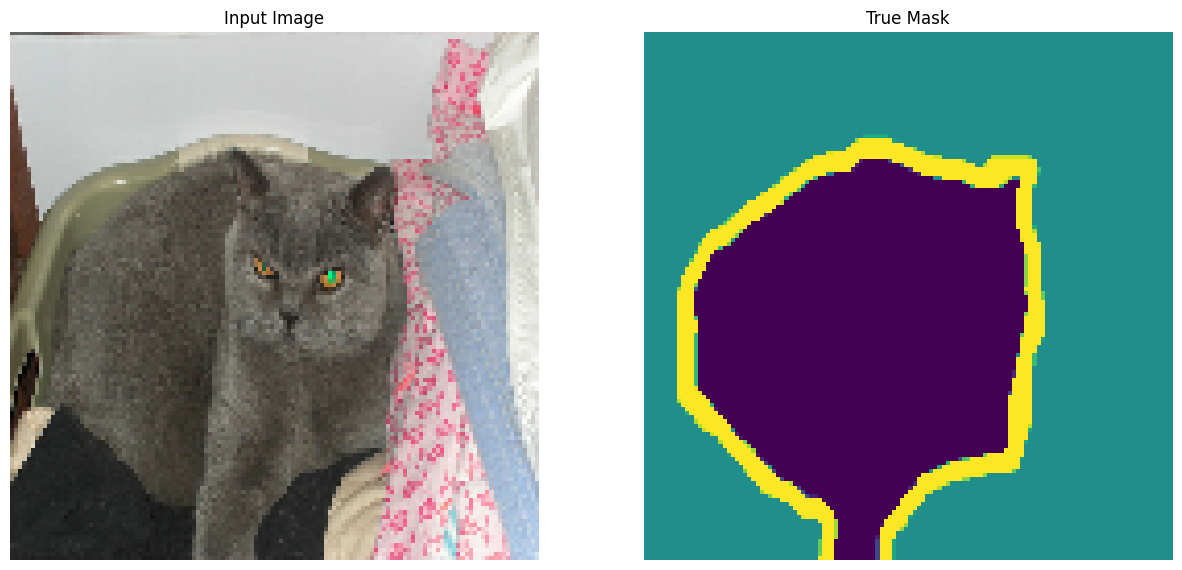

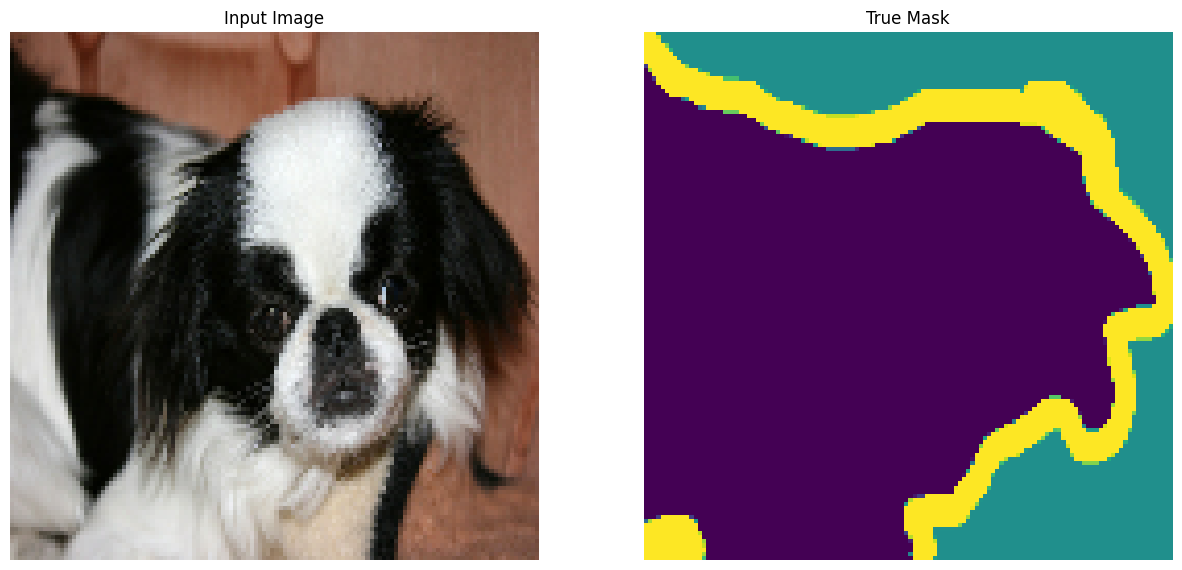

In [15]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])